In [68]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
Encode = preprocessing.LabelEncoder()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline,make_union
from sklearn import metrics
import pandas as pd
import numpy as np
from collections import Counter
import re
import nltk
from gensim.corpora import Dictionary
from sklearn.preprocessing import LabelEncoder
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import sent_tokenize, word_tokenize
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from subprocess import check_output
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [69]:
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

In [70]:
def only_letters(raw_text):
    #raw_text2=tokenizer.tokenize(replacer.replace(raw_text))
    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    meaningful_words = [w for w in words if w not in stopword_set]

    # join the cleaned words in a list
    cleaned_word_list = " ".join(meaningful_words)
    #lemmas = [wordnet_lemmatizer.lemmatize(t) for t in meaningful_words]

    return cleaned_word_list

In [71]:
df = pd.read_csv("/home/ajadhav/Nostalgic/YoutubeComments.csv",usecols=['Comments','Nostalgic'],encoding='latin-1')
df = df.dropna(subset=['Nostalgic'], how='all')
df['Comments'] = df['Comments'].str.replace('\d+', '')

In [72]:
df.head()

,Comments,Nostalgic
0,.One of the many reasons I keep coming back to...,Yes
1,.Best song ever made,No
2,.quite possibly the grooviest chick i've ever ...,No
3,.If only had a timemachine get the hell out th...,Yes
4,.I wish I could time machine my head between t...,Yes


In [73]:
df['only_letter'] = df.Comments.apply(only_letters)

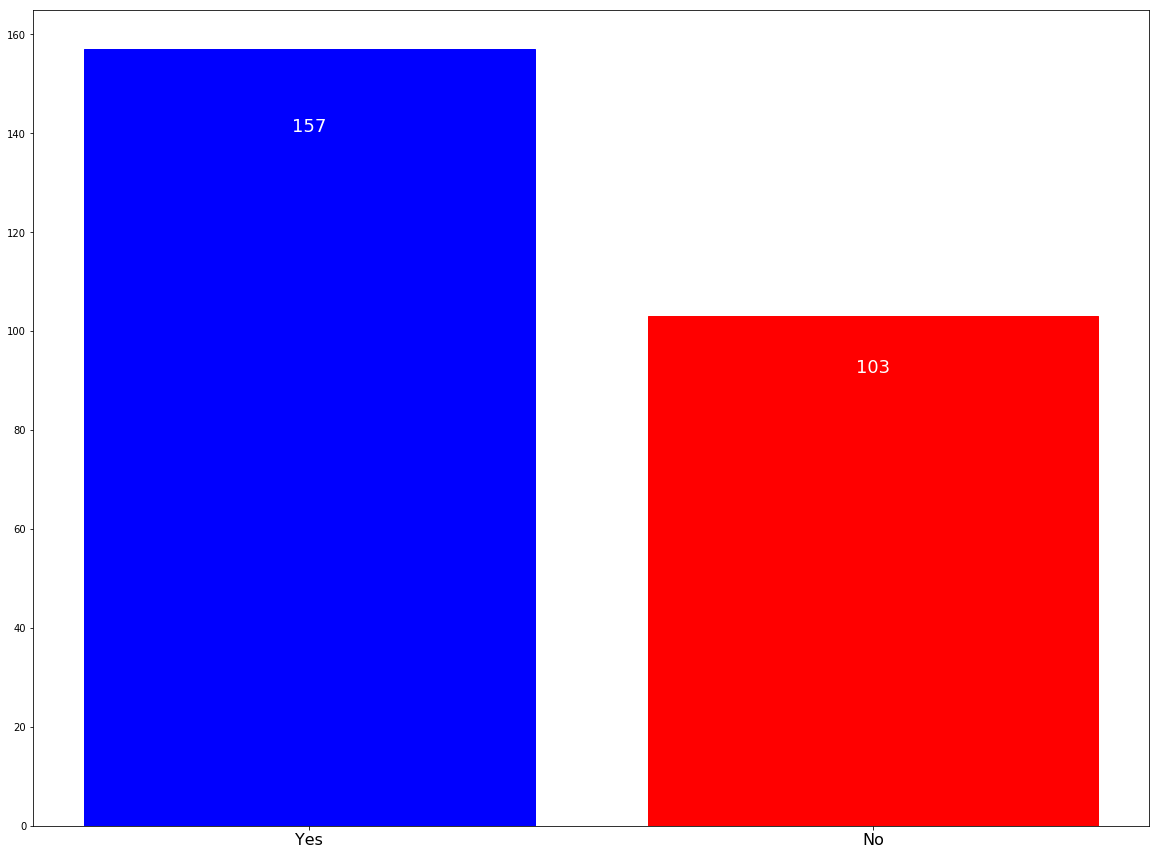

In [74]:
fig, ax = plt.subplots(1,1,figsize=(20,15))

author_vc = df.Nostalgic.value_counts()

ax.bar(range(2), author_vc)
ax.set_xticks(range(2))
ax.set_xticklabels(author_vc.index, fontsize=16)

for rect, c, value in zip(ax.patches, ['b', 'r'], author_vc.values):
    rect.set_color(c)
    height = rect.get_height()
    width = rect.get_width()
    x_loc = rect.get_x()
    ax.text(x_loc + width/2, 0.9*height, value, ha='center', va='center', fontsize=18, color='white')

In [75]:
document_lengths = np.array(list(map(len, df.Comments.str.split(' '))))
print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 21.865384615384617.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 105.


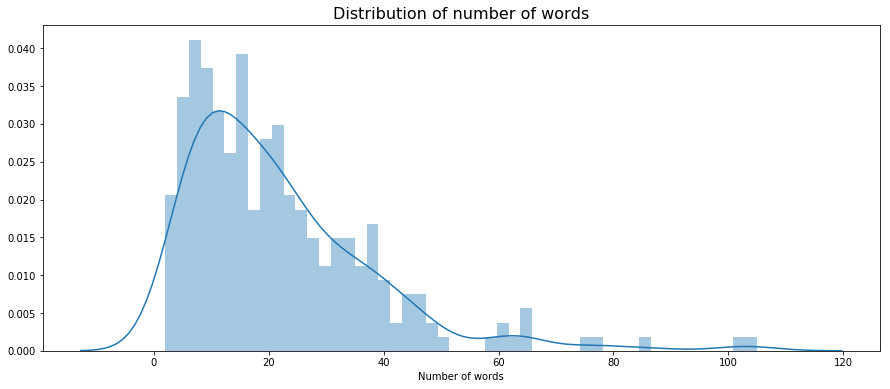

In [76]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);

In [77]:
print("There are {} documents with tops 10 words.".format(sum(document_lengths <= 10)))

There are 71 documents with tops 10 words.


In [78]:
df[document_lengths <= 10].head()

,Comments,Nostalgic,only_letter
1,.Best song ever made,No,best song ever made
5,.She reminds me of a classmate,No,reminds classmate
10,.This song reminds me on my father,No,song reminds father
11,.gives me good memories first love out on the ...,No,gives good memories first love streets
13,.to me the greatest song in music history... :),No,greatest song music history


In [79]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [80]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['Tweet'] = df.Comments.str.lower()
    df['document_sentences'] = df.Comments.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(df)

In [81]:
df.head()

,Comments,Nostalgic,only_letter,Tweet,document_sentences,tokenized_sentences
0,.One of the many reasons I keep coming back to...,Yes,one many reasons keep coming back video remind...,.one of the many reasons i keep coming back to...,"[, One of the many reasons I keep coming back ...","[[One, of, the, many, reasons, I, keep, coming..."
1,.Best song ever made,No,best song ever made,.best song ever made,"[, Best song ever made]","[[Best, song, ever, made]]"
2,.quite possibly the grooviest chick i've ever ...,No,quite possibly grooviest chick ever seen entir...,.quite possibly the grooviest chick i've ever ...,"[, quite possibly the grooviest chick i've eve...","[[quite, possibly, the, grooviest, chick, i, v..."
3,.If only had a timemachine get the hell out th...,Yes,timemachine get hell era go back one grewup,.if only had a timemachine get the hell out th...,"[, If only had a timemachine get the hell out ...","[[If, only, had, a, timemachine, get, the, hel..."
4,.I wish I could time machine my head between t...,Yes,wish could time machine head thighs love date,.i wish i could time machine my head between t...,"[, I wish I could time machine my head between...","[[I, wish, I, could, time, machine, my, head, ..."


In [82]:
def lda_get_good_tokens(df):
    df['Comments'] = df.Comments.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.Comments))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(df)

In [83]:
df.head()

,Comments,Nostalgic,only_letter,Tweet,document_sentences,tokenized_sentences,tokenized_text
0,.one of the many reasons i keep coming back to...,Yes,one many reasons keep coming back video remind...,.one of the many reasons i keep coming back to...,"[, One of the many reasons I keep coming back ...","[[One, of, the, many, reasons, I, keep, coming...","[one, of, the, many, reasons, i, keep, coming,..."
1,.best song ever made,No,best song ever made,.best song ever made,"[, Best song ever made]","[[Best, song, ever, made]]","[best, song, ever, made]"
2,.quite possibly the grooviest chick i've ever ...,No,quite possibly grooviest chick ever seen entir...,.quite possibly the grooviest chick i've ever ...,"[, quite possibly the grooviest chick i've eve...","[[quite, possibly, the, grooviest, chick, i, v...","[quite, possibly, the, grooviest, chick, i, ve..."
3,.if only had a timemachine get the hell out th...,Yes,timemachine get hell era go back one grewup,.if only had a timemachine get the hell out th...,"[, If only had a timemachine get the hell out ...","[[If, only, had, a, timemachine, get, the, hel...","[if, only, had, a, timemachine, get, the, hell..."
4,.i wish i could time machine my head between t...,Yes,wish could time machine head thighs love date,.i wish i could time machine my head between t...,"[, I wish I could time machine my head between...","[[I, wish, I, could, time, machine, my, head, ...","[i, wish, i, could, time, machine, my, head, b..."


In [84]:
tokenized_only_dict = Counter(np.concatenate(df.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [85]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

In [86]:
tokenized_only_df.head()

,count
the,227
i,213
this,187
and,161
song,136


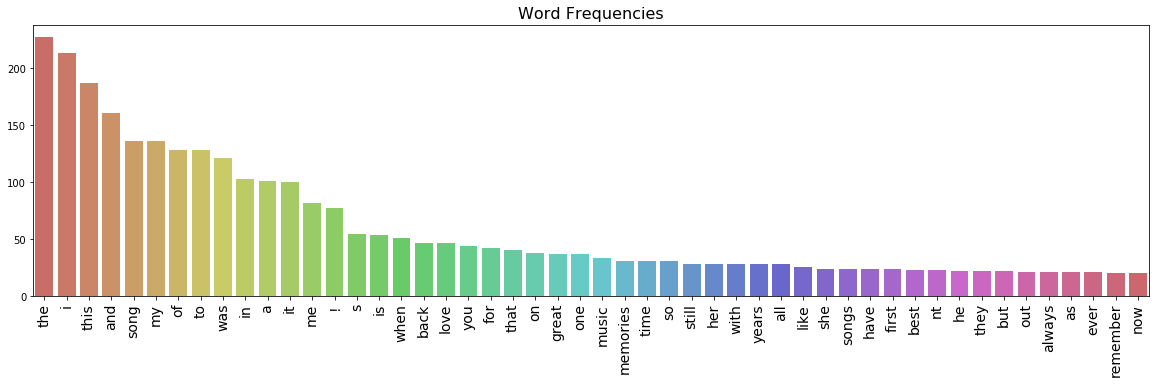

In [87]:
# I made a function out of this since I will use it again later on 
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);

In [88]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('english')
    # we'll add our own special word in here 'qwerty'
    our_special_word = ['this']
    stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(df)

In [89]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(df)

In [90]:
df.head()

,Comments,Nostalgic,only_letter,Tweet,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text
0,.one of the many reasons i keep coming back to...,Yes,one many reasons keep coming back video remind...,.one of the many reasons i keep coming back to...,"[, One of the many reasons I keep coming back ...","[[One, of, the, many, reasons, I, keep, coming...","[one, of, the, many, reasons, i, keep, coming,...","[one, many, reasons, keep, coming, back, video...","[one, many, reason, keep, coming, back, video,...","[one, mani, reason, keep, come, back, video, r..."
1,.best song ever made,No,best song ever made,.best song ever made,"[, Best song ever made]","[[Best, song, ever, made]]","[best, song, ever, made]","[best, song, ever, made]","[best, song, ever, made]","[best, song, ever, made]"
2,.quite possibly the grooviest chick i've ever ...,No,quite possibly grooviest chick ever seen entir...,.quite possibly the grooviest chick i've ever ...,"[, quite possibly the grooviest chick i've eve...","[[quite, possibly, the, grooviest, chick, i, v...","[quite, possibly, the, grooviest, chick, i, ve...","[quite, possibly, grooviest, chick, ever, seen...","[quite, possibly, grooviest, chick, ever, seen...","[quit, possibl, grooviest, chick, ever, seen, ..."
3,.if only had a timemachine get the hell out th...,Yes,timemachine get hell era go back one grewup,.if only had a timemachine get the hell out th...,"[, If only had a timemachine get the hell out ...","[[If, only, had, a, timemachine, get, the, hel...","[if, only, had, a, timemachine, get, the, hell...","[timemachine, get, hell, era, go, back, one, g...","[timemachine, get, hell, era, go, back, one, g...","[timemachin, get, hell, era, go, back, one, gr..."
4,.i wish i could time machine my head between t...,Yes,wish could time machine head thighs love date,.i wish i could time machine my head between t...,"[, I wish I could time machine my head between...","[[I, wish, I, could, time, machine, my, head, ...","[i, wish, i, could, time, machine, my, head, b...","[wish, could, time, machine, head, thighs, lov...","[wish, could, time, machine, head, thigh, love...","[wish, could, time, machin, head, thigh, love,..."


In [91]:
dictionary = Dictionary(documents=df.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 918 words.


In [92]:
dictionary.filter_extremes(no_above=0.8, no_below=2)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 355 words.


In [93]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(df)

In [94]:
df.head()

,Comments,Nostalgic,only_letter,Tweet,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow
0,.one of the many reasons i keep coming back to...,Yes,one many reasons keep coming back video remind...,.one of the many reasons i keep coming back to...,"[, One of the many reasons I keep coming back ...","[[One, of, the, many, reasons, I, keep, coming...","[one, of, the, many, reasons, i, keep, coming,...","[one, many, reasons, keep, coming, back, video...","[one, many, reason, keep, coming, back, video,...","[one, mani, reason, keep, come, back, video, r...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1..."
1,.best song ever made,No,best song ever made,.best song ever made,"[, Best song ever made]","[[Best, song, ever, made]]","[best, song, ever, made]","[best, song, ever, made]","[best, song, ever, made]","[best, song, ever, made]","[(11, 1), (13, 1), (14, 1), (15, 1)]"
2,.quite possibly the grooviest chick i've ever ...,No,quite possibly grooviest chick ever seen entir...,.quite possibly the grooviest chick i've ever ...,"[, quite possibly the grooviest chick i've eve...","[[quite, possibly, the, grooviest, chick, i, v...","[quite, possibly, the, grooviest, chick, i, ve...","[quite, possibly, grooviest, chick, ever, seen...","[quite, possibly, grooviest, chick, ever, seen...","[quit, possibl, grooviest, chick, ever, seen, ...","[(14, 1), (16, 1), (17, 1), (18, 1), (19, 1)]"
3,.if only had a timemachine get the hell out th...,Yes,timemachine get hell era go back one grewup,.if only had a timemachine get the hell out th...,"[, If only had a timemachine get the hell out ...","[[If, only, had, a, timemachine, get, the, hel...","[if, only, had, a, timemachine, get, the, hell...","[timemachine, get, hell, era, go, back, one, g...","[timemachine, get, hell, era, go, back, one, g...","[timemachin, get, hell, era, go, back, one, gr...","[(0, 1), (4, 1), (20, 1), (21, 1), (22, 1)]"
4,.i wish i could time machine my head between t...,Yes,wish could time machine head thighs love date,.i wish i could time machine my head between t...,"[, I wish I could time machine my head between...","[[I, wish, I, could, time, machine, my, head, ...","[i, wish, i, could, time, machine, my, head, b...","[wish, could, time, machine, head, thighs, lov...","[wish, could, time, machine, head, thigh, love...","[wish, could, time, machin, head, thigh, love,...","[(7, 1), (23, 1), (24, 1), (25, 1), (26, 1)]"


In [95]:
# we make a function such that later on when we make the submission, we don't need to write duplicate code
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

In [96]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [97]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

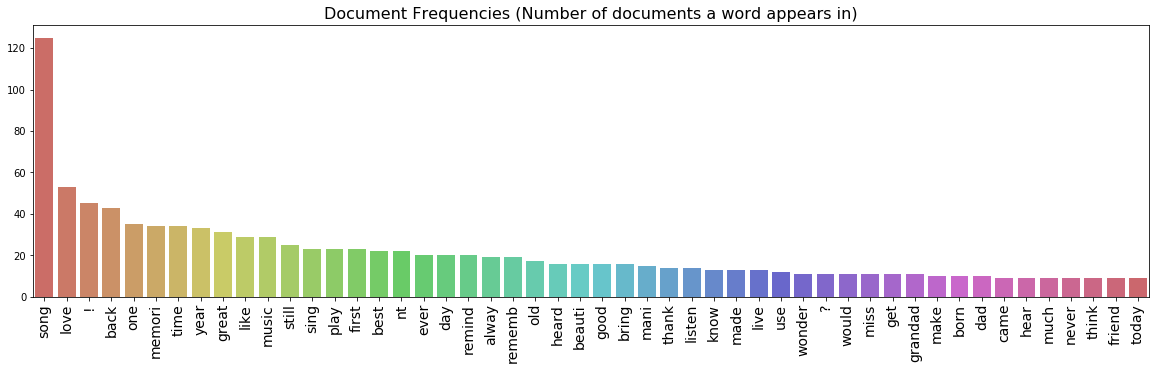

In [98]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

In [99]:
corpus = df.bow

In [100]:
%%time
num_topics = 150
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

CPU times: user 20.8 s, sys: 964 ms, total: 21.8 s
Wall time: 21.1 s


In [101]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

df['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      df.bow))

In [102]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [103]:
sentences = []
for sentence_group in df.tokenized_sentences:
    sentences.extend(sentence_group)

In [104]:
%%time
# Set values for various parameters
num_features = 2000    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

CPU times: user 1.37 s, sys: 2.87 ms, total: 1.38 s
Wall time: 485 ms


In [105]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

df['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      df.tokenized_sentences))

In [106]:
df.head()

,Comments,Nostalgic,only_letter,Tweet,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,lda_features,w2v_features
0,.one of the many reasons i keep coming back to...,Yes,one many reasons keep coming back video remind...,.one of the many reasons i keep coming back to...,"[, One of the many reasons I keep coming back ...","[[One, of, the, many, reasons, I, keep, coming...","[one, of, the, many, reasons, i, keep, coming,...","[one, many, reasons, keep, coming, back, video...","[one, many, reason, keep, coming, back, video,...","[one, mani, reason, keep, come, back, video, r...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[0.00183170773131, 0.00169343901476, 0.0015745...","[-0.0245331, -0.0112105, -0.00601321, 0.019957..."
1,.best song ever made,No,best song ever made,.best song ever made,"[, Best song ever made]","[[Best, song, ever, made]]","[best, song, ever, made]","[best, song, ever, made]","[best, song, ever, made]","[best, song, ever, made]","[(11, 1), (13, 1), (14, 1), (15, 1)]","[0.00622780628646, 0.00575769265017, 0.0053535...","[-0.0251674, -0.0113868, -0.00620116, 0.020289..."
2,.quite possibly the grooviest chick i've ever ...,No,quite possibly grooviest chick ever seen entir...,.quite possibly the grooviest chick i've ever ...,"[, quite possibly the grooviest chick i've eve...","[[quite, possibly, the, grooviest, chick, i, v...","[quite, possibly, the, grooviest, chick, i, ve...","[quite, possibly, grooviest, chick, ever, seen...","[quite, possibly, grooviest, chick, ever, seen...","[quit, possibl, grooviest, chick, ever, seen, ...","[(14, 1), (16, 1), (17, 1), (18, 1), (19, 1)]","[0.00518983857205, 0.00479807720848, 0.5277902...","[-0.0258062, -0.0117313, -0.00639015, 0.020796..."
3,.if only had a timemachine get the hell out th...,Yes,timemachine get hell era go back one grewup,.if only had a timemachine get the hell out th...,"[, If only had a timemachine get the hell out ...","[[If, only, had, a, timemachine, get, the, hel...","[if, only, had, a, timemachine, get, the, hell...","[timemachine, get, hell, era, go, back, one, g...","[timemachine, get, hell, era, go, back, one, g...","[timemachin, get, hell, era, go, back, one, gr...","[(0, 1), (4, 1), (20, 1), (21, 1), (22, 1)]","[0.00518983857205, 0.00479807720848, 0.0044613...","[-0.0258184, -0.0118119, -0.00628909, 0.020828..."
4,.i wish i could time machine my head between t...,Yes,wish could time machine head thighs love date,.i wish i could time machine my head between t...,"[, I wish I could time machine my head between...","[[I, wish, I, could, time, machine, my, head, ...","[i, wish, i, could, time, machine, my, head, b...","[wish, could, time, machine, head, thighs, lov...","[wish, could, time, machine, head, thigh, love...","[wish, could, time, machin, head, thigh, love,...","[(7, 1), (23, 1), (24, 1), (25, 1), (26, 1)]","[0.00518983857205, 0.207970759123, 0.004461309...","[-0.0235909, -0.0108278, -0.00582244, 0.019086..."


In [107]:
label_encoder = LabelEncoder()

label_encoder.fit(df.Nostalgic)
df['Nostalgic'] = label_encoder.transform(df.Nostalgic)

In [108]:
# since train_data['lda_features'] and train_data['w2v_features'] don't have the needed shape and type yet,
# we first have to transform every entry
X_train_lda = np.array(list(map(np.array, df.lda_features)))
X_train_w2v = np.array(list(map(np.array, df.w2v_features)))
X_train_combined = np.append(X_train_lda, X_train_w2v, axis=1)

#df['CombinedFeatures']  = X_train_combined

In [109]:
def get_cross_validated_model(model, param_grid, X, y, nr_folds=5):
    grid_cv = GridSearchCV(model, param_grid=param_grid, scoring='neg_log_loss', cv=nr_folds, n_jobs=-1, verbose=True)
    best_model = grid_cv.fit(X, y)
    result_df = pd.DataFrame(best_model.cv_results_)
    show_columns = ['mean_test_score', 'mean_train_score', 'rank_test_score']
    for col in result_df.columns:
        if col.startswith('param_'):
            show_columns.append(col)
    display(result_df[show_columns].sort_values(by='rank_test_score').head())
    return best_model

In [110]:
# store all models in a dictionary
models = dict()

In [111]:
# LDA and Word2Vec combined
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_combined = get_cross_validated_model(lr, param_grid, X_train_combined, df.Nostalgic)

models['best_lr_combined'] = best_lr_combined

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


,mean_test_score,mean_train_score,rank_test_score,param_penalty
0,-0.665660,-0.630238,1,l1
1,-0.688383,-0.599444,2,l2


In [112]:
# Word2Vec features only
from sklearn.svm import SVC
svm = SVC(probability=True)
param_grid = {'C': [1, 10, 100, 1000]}

best_svm_combined = get_cross_validated_model(svm, param_grid, X_train_combined, df.Nostalgic)

models['best_svm_combined'] = best_svm_combined

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.1s finished


,mean_test_score,mean_train_score,rank_test_score,param_C
3,-0.675949,-0.666185,1,1000
2,-0.678875,-0.687309,2,100
1,-0.679298,-0.684918,3,10
0,-0.681096,-0.683935,4,1


In [122]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

param_grid = {}

best_gnb_combined = get_cross_validated_model(gnb, param_grid, X_train_combined, df.Nostalgic)

models['best_gnb_combined'] = best_gnb_combined


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


,mean_test_score,mean_train_score,rank_test_score
0,-15.409608,-11.881147,1


In [123]:
for name, model in models.items():
    print("Model {} has a test score of: {:0.4f}".format(name, float(model.best_score_)))

Model best_lr_combined has a test score of: -0.6657
Model best_svm_combined has a test score of: -0.6759
Model best_gnb_combined has a test score of: -15.4096


In [124]:
TestData = pd.read_csv("/home/ajadhav/Nostalgic/YoutubeComments2.csv",usecols=['Comments','Nostalgic'],encoding='latin-1')
TestData = TestData.dropna(subset=['Nostalgic'], how='all')

In [125]:
TestData.head()

,Comments,Nostalgic
0,He was great why does everything need to be ab...,No
1,"truly you are the wonder of you, thanks elvis ...",Yes
2,"Oldies are my favorite. Timeless, classic, swe...",No
3,Love this era of music proper musicians,No
4,"as a rnb and hiphop lover from 90'still now, m...",No


In [126]:
lda_preprocessing(TestData)
w2v_preprocessing(TestData)

In [127]:
TestData['lda_features'] = list(map(lambda doc:
                                     document_to_lda_features(LDAmodel, doc),
                                     TestData.bow))

TestData['w2v_features'] = list(map(lambda sen_group:
                                     get_w2v_features(W2Vmodel, sen_group),
                                     TestData.tokenized_sentences))

In [128]:
X_test_lda = np.array(list(map(np.array, TestData.lda_features)))
X_test_w2v = np.array(list(map(np.array, TestData.w2v_features)))
X_test_combined = np.append(X_test_lda, X_test_w2v, axis=1)

In [129]:
#best_lr_combined.predict_proba(X_test_combined)[:,1]>0.5

Prediction = np.where(best_lr_combined.predict_proba(X_test_combined)[:,1]>=0.65, 'Yes', 'No')

In [130]:
from sklearn.metrics import confusion_matrix
confusion_matrix(TestData.Nostalgic, Prediction)

array([[291,   3],
       [ 98,  49]])

In [131]:
from sklearn.metrics import classification_report
print(classification_report(TestData.Nostalgic, Prediction))

             precision    recall  f1-score   support

         No       0.75      0.99      0.85       294
        Yes       0.94      0.33      0.49       147

avg / total       0.81      0.77      0.73       441

